In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

In [3]:
BASE_PATH = '/content/drive/MyDrive/Face Recognition'
TRAIN_DIR = os.path.join(BASE_PATH, 'Train Images')
TEST_DIR  = os.path.join(BASE_PATH, 'Test Images')
AUG_DIR   = os.path.join(BASE_PATH, 'Augmented')
CROPPED_DIR   = os.path.join(BASE_PATH, 'Cropped')
os.makedirs(AUG_DIR, exist_ok=True)
os.makedirs(CROPPED_DIR, exist_ok=True)

In [4]:
# Load OpenCV’s pretrained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +
                                     'haarcascade_frontalface_default.xml')

def crop_and_blur_background(img_path, out_path):
    img = cv2.imread(img_path)
    # Add a check to see if the image was loaded successfully
    if img is None:
        print(f"Error: Unable to load image from {img_path}")
        return False  # Indicate failure

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    if len(faces)==0:
        return False  # no face found
    # pick largest face
    x,y,w,h = max(faces, key=lambda box: box[2]*box[3])
    # Create mask for face region
    mask = np.zeros_like(img)
    mask[y:y+h, x:x+w] = img[y:y+h, x:x+w]
    # Blur entire image
    blurred = cv2.GaussianBlur(img, (51,51), 0)
    # Composite: keep face region sharp, blur background
    composite = np.where(mask!=0, img, blurred)
    # Corrected the slicing to use the width 'w' instead of height 'h' in the column slice
    face_crop = cv2.resize(composite[y:y+h, x:x+w], (227,227))
    cv2.imwrite(out_path, face_crop)
    return True



In [5]:
# 3.1 Crop & blur all train images into class‑subfolders
for cls in os.listdir(TRAIN_DIR):
    src = os.path.join(TRAIN_DIR, cls)
    dst = os.path.join(CROPPED_DIR, cls)
    os.makedirs(dst, exist_ok=True)
    for fname in os.listdir(src):
        in_path  = os.path.join(src, fname)
        out_path = os.path.join(dst, fname)
        crop_and_blur_background(in_path, out_path)

# 3.2 Augment each class up to 1000 images
os.makedirs(AUG_DIR, exist_ok=True)
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True, fill_mode='nearest'
)

for cls in os.listdir(CROPPED_DIR):
    src_dir = os.path.join(CROPPED_DIR, cls)
    dst_dir = os.path.join(AUG_DIR, cls)
    os.makedirs(dst_dir, exist_ok=True)
    images = os.listdir(src_dir)
    count = len(images)
    # copy originals first
    for img_name in images:
        cv2.imwrite(os.path.join(dst_dir, img_name),
                    cv2.imread(os.path.join(src_dir, img_name)))
    gen_iter = datagen.flow_from_directory(
        directory=CROPPED_DIR,
        classes=[cls],
        target_size=(227,227),
        batch_size=1,
        save_to_dir=dst_dir,
        save_prefix='aug_',
        save_format='jpg'
    )
    # generate until 1000
    for _ in range(1000 - count):
        next(gen_iter)

Found 96 images belonging to 1 classes.
Found 115 images belonging to 1 classes.
Found 132 images belonging to 1 classes.
Found 23 images belonging to 1 classes.


In [6]:
# Load augmented data into arrays
X, y = [], []
label_map = {name:idx for idx,name in enumerate(sorted(os.listdir(AUG_DIR)))}

for cls, idx in label_map.items():
    cls_dir = os.path.join(AUG_DIR, cls)
    for fname in os.listdir(cls_dir):
        img = cv2.imread(os.path.join(cls_dir, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)
        y.append(idx)

X = np.array(X, dtype='float32')
y = np.array(y, dtype='int32')

# Train/Val split 80/20
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Load & preprocess test images
X_test, y_test = [], []
for cls, idx in label_map.items():
    cls_dir = os.path.join(TEST_DIR, cls)
    for fname in os.listdir(cls_dir):
        img = cv2.imread(os.path.join(cls_dir, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (227,227))
        X_test.append(img)
        y_test.append(idx)
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test, dtype='int32')

# Normalize by mean image from training set
mean_img = np.mean(X_train, axis=0)
X_train = X_train - mean_img
X_val   = X_val   - mean_img
X_test  = X_test  - mean_img


In [7]:
model = keras.Sequential([
    keras.Input(shape=(227,227,3)),

    layers.Conv2D(96, (11,11), strides=4, activation='relu'),
    layers.MaxPooling2D(3, strides=2),
    layers.BatchNormalization(),

    layers.Conv2D(256, (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(3, strides=2),
    layers.BatchNormalization(),

    layers.Conv2D(384, (3,3), padding='same', activation='relu'),
    layers.Conv2D(384, (3,3), padding='same', activation='relu'),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(3, strides=2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(len(label_map), activation='softmax')
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,332,932 (222.52 MB)

 Trainable params: 58,315,332 (222.46 MB)

 Non-trainable params: 17,600 (68.75 KB)

In [8]:
# 1. Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 2. Configure EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

# 3. Train with both callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=0,                           # turn off default Keras progress bars
    callbacks=[
        early_stop,
        TqdmCallback(verbose=1)         # show tqdm progress per epoch and batch
    ]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.


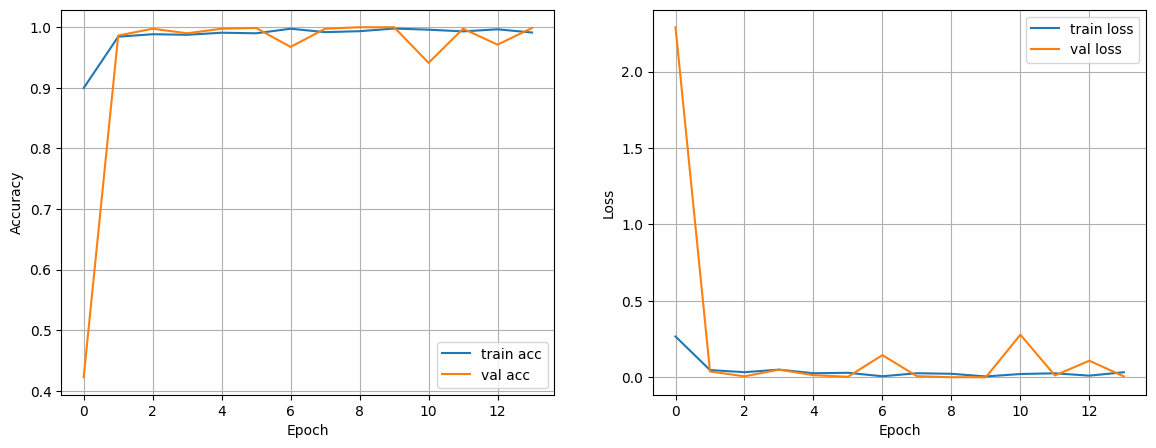

In [9]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)

plt.show()


In [10]:
def print_metrics(name, y_true, y_pred):
    print(f'=== {name} Metrics ===')
    print('Accuracy :', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, average='weighted'))
    print('Recall   :', recall_score(y_true, y_pred, average='weighted'))
    print('F1 Score :', f1_score(y_true, y_pred, average='weighted'))
    print(classification_report(y_true, y_pred, target_names=label_map.keys()))

# Train set
y_train_pred = np.argmax(model.predict(X_train), axis=1)
print_metrics('Train', y_train, y_train_pred)

# Validation set
y_val_pred = np.argmax(model.predict(X_val), axis=1)
print_metrics('Validation', y_val, y_val_pred)

# Test set
y_test_pred = np.argmax(model.predict(X_test), axis=1)
print_metrics('Test', y_test, y_test_pred)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
=== Train Metrics ===
Accuracy : 0.999375
Precision: 0.999375
Recall   : 0.999375
F1 Score : 0.999375
                   precision    recall  f1-score   support

Md._Mirazul_Hasan       1.00      1.00      1.00       800
           Nayeem       1.00      1.00      1.00       800
    Raiyan_Sayeed       1.00      1.00      1.00       800
     Zahid_Sadman       1.00      1.00      1.00       800

         accuracy                           1.00      3200
        macro avg       1.00      1.00      1.00      3200
     weighted avg       1.00      1.00      1.00      3200

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
=== Validation Metrics ===
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0
                   precision    recall  f1-score   support

Md._Mirazul_Hasan       1.00      1.00      1.00       200
           Nayeem       1.00      1.00      1.00       200
    Raiyan_Sayeed       1.00      1.00      1.00       200
     Zahid_Sadman

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [11]:
np.save(f'{BASE_PATH}/mean_image.npy', mean_img)

In [12]:
model.save(f'{BASE_PATH}/alexnet_face_recognition.h5')
print('Model saved.')

Model saved.
